In [1]:
#Import Libraries

In [1]:
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch
from skimage.color import rgb2lab, lab2rgb

In [2]:
import warnings
warnings.filterwarnings('ignore')
torch.cuda.is_available()

True

In [3]:
from torchsummary import summary

In [4]:
# Path to directory with images
#It expects greyscale and colour image pairs to be sequentially named from 0 and to be present in two different folders with same name
home = 'path'
total_images = len(os.listdir(home+'color'))

In [5]:
random_indices = random.sample(list(range(total_images)),total_images)
train_nums = round(total_images*0.8)
train_indices = random_indices[:train_nums]
test_indices = random_indices[train_nums:]
len(train_indices), len(test_indices)

(5703, 1426)

In [6]:
class EncoderDataset(Dataset):
    def __init__(self, indices, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_indices = indices
        self.gray_path = img_dir+'gray/'
        self.color_path = img_dir+'color/'
    
    def __len__(self):
        return len(self.img_indices)
        
    def __getitem__(self, idx):
        img_name = str(idx)+'.jpg'
        image = read_image(self.gray_path+img_name)
        image = image.unsqueeze(0)
        image = F.interpolate(image,(160,160))
        image = image.squeeze(0)
        image = image.permute(1,2,0)
        image = image.repeat(1,1,3)
        image = image.permute(2,0,1)
        label = read_image(self.color_path+img_name)
        label = label.unsqueeze(0)
        label = F.interpolate(label,(160,160))
        label = label.squeeze(0)
        label = label.permute(1,2,0)
        label = label.permute(2,0,1)
        image = torch.tensor(rgb2lab(image.permute(1,2,0)/255))
        label = torch.tensor(rgb2lab(label.permute(1,2,0)/255))
        
        image = (image + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])
        label = (label + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])
        
        image = image.permute(2,0,1)
        label = label.permute(2,0,1)

        image = image[:1,:,:]
        label = label[1:,:,:]

        #L channel would be image and ab channel be labels , img_name for record keeping
        return image, label, img_name

In [7]:
import torch
from torchvision.transforms import transforms

#Applying normalization and basic augmentation
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [9]:
#Test Train Datasets
train_dataset = EncoderDataset(indices = train_indices,img_dir = home,transform=train_transforms)
test_dataset = EncoderDataset(indices = test_indices,img_dir = home,transform=train_transforms)
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=True, pin_memory=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0)

Sample Image 
- Remember we have 1 color channel input for image and 2 color channel output of label

In [10]:
img,label, img_name = next(iter(train_dataloader))
sample_image,sample_label = img[0], label[0]
print(sample_image.shape, sample_label.shape)
print(img_name[0])

torch.Size([1, 160, 160]) torch.Size([2, 160, 160])
5384.jpg


Visualize Image

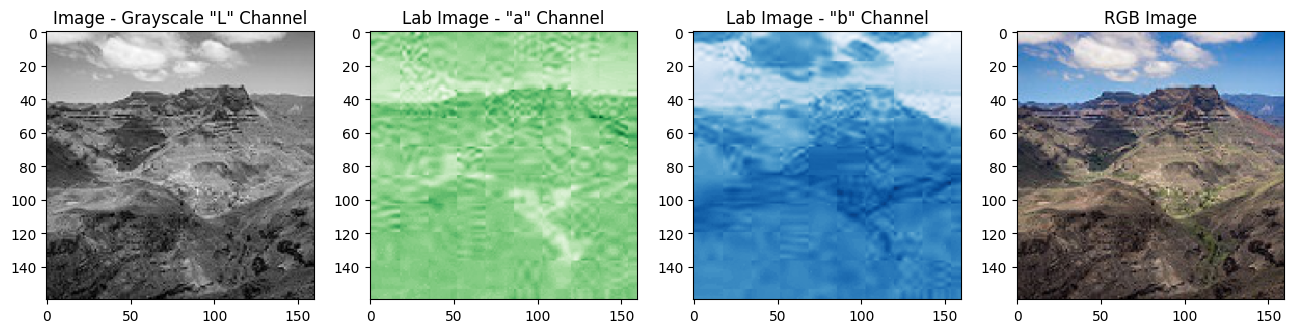

In [13]:
fig = plt.figure(figsize=(16,16))
plt.subplot(441)
plt.imshow(sample_image.permute(1,2,0),cmap='gray')
plt.title('Image - Grayscale "L" Channel')
plt.subplot(442)
plt.imshow(sample_label.permute(1,2,0)[:,:,0],cmap='Greens')
plt.title('Lab Image - "a" Channel')

plt.subplot(443)
plt.imshow(sample_label.permute(1,2,0)[:,:,1],cmap='Blues')
plt.title('Lab Image - "b" Channel')

plt.subplot(444)
color_image = torch.cat((sample_image,sample_label),dim=0).permute(1,2,0)
color_image = color_image * torch.tensor([100,255,255]) -torch.tensor([0,128,128])
color_image = lab2rgb(color_image)
plt.imshow(color_image)
plt.title('RGB Image')
plt.show()

In [14]:
# number of epochs to train the model
n_epochs = 150
experiment = "Experiment12"

In [15]:
from torchvision.models import ResNet152_Weights
#from torchvision.models import ResNet152_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR

import torch
torch.backends.cuda.matmul.allow_tf32=False
torch.backends.cudnn.allow_tf32=False
import torchvision
from torch import nn
from torchvision import models


class ColorizationNet(nn.Module):
    def __init__(self, midlevel_input_size=512, global_input_size=512):
        super(ColorizationNet, self).__init__()
        self.midlevel_input_size = midlevel_input_size
        self.global_input_size = global_input_size

        self.conv1 = nn.Conv2d(midlevel_input_size, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=2)

        print('Loaded colorization net.')

    def forward(self, midlevel_input): #, global_input):

        # Convolutional layers and upsampling
        x = F.relu(self.bn2(self.conv1(midlevel_input)))
        x = self.upsample(x)
        x = F.relu(self.bn3(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.upsample(x)
        x = F.relu(self.conv4(x))
        x = self.upsample(self.conv5(x))
        return x


class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()

        # Build ResNet and change first conv layer to accept single-channel input, weights would be deafult with 1000 classes or 255 classes
        #with no weights
        resnet_model = models.resnet152(num_classes=1000, weights=ResNet152_Weights.DEFAULT)
        #resnet_gray_model = models.resnet152(num_classes=255)
        resnet_model.conv1.weight = nn.Parameter(resnet_model.conv1.weight.sum(dim=1).unsqueeze(1).data)

        # Extract midlevel and global features from resnet_model
        self.midlevel_resnet = nn.Sequential(*list(resnet_model.children())[0:6])
        self.fusion_and_colorization_net = ColorizationNet()

    def forward(self, input_image):

        # Pass input through resnet_model to extract features
        midlevel_output = self.midlevel_resnet(input_image)

        # Combine features in fusion layer and upsample
        output = self.fusion_and_colorization_net(midlevel_output)
        return output

model = ColorNet()
model.to('cuda')
# Define a loss function and optimizer
criterion = nn.MSELoss().to('cuda')

optimizer = torch.optim.AdamW(model.parameters(),lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs) #added for variable lr

model.eval()


Loaded colorization net.


ColorNet(
  (midlevel_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Co

In [16]:
#For mixed precision, code commented for now
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

In [17]:
import math
from PIL import ImageChops

def rmsdiff(im1, im2):
    "Calculate the root-mean-square difference between two images"
    diff = ImageChops.difference(im1, im2)
    h = diff.histogram()
    sq = (value*((idx%256)**2) for idx, value in enumerate(h))
    sum_of_squares = sum(sq)
    rms = math.sqrt(sum_of_squares/float(im1.size[0] * im1.size[1]))
    return rms

In [18]:
from tqdm import tqdm

train_losses = []
test_losses = []
learning_rates = []
params = []

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for data in tqdm(train_dataloader):
        images, labels, image_name = data
        images = images.float().to('cuda')
        labels = labels.float().to('cuda')
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    scheduler.step()
        #Commented code for mixed precision training
        #with torch.autocast(device_type='cuda', dtype=torch.float32, enabled=use_amp):
        # with torch.autocast(enabled=True):
        #     images, labels = data
        #     images = images.float().to('cuda')
        #     labels = labels.float().to('cuda')
        #     outputs = model(images)
        #     loss = criterion(outputs, labels)

        # train_loss += loss.item()*images.size(0)
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

    learning_rate = optimizer.param_groups[0]["lr"]
    learning_rates.append((epoch, learning_rate))
    train_loss = train_loss/len(train_dataloader)
    train_losses.append((epoch, train_loss))
    total_params = sum(
	param.numel() for param in model.parameters())
    params.append((epoch, total_params))

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    
    test_loss = 0
    # Turn off gradients for validation
    with torch.no_grad():
        model.eval()
        for images, labels, img_name in test_dataloader:
            #with torch.autocast(device_type='cuda', dtype=torch.float32, enabled=use_amp):
            #with torch.autocast(enabled=True):
            images, labels = images.to('cuda'), labels.to('cuda')
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()*images.size(0)

    model.train()
    test_loss = test_loss/len(test_dataloader)
    print("Test Loss: {:.3f}.. ".format(test_loss))
    test_losses.append((epoch, test_loss))

    with open('pathOnDisk' + experiment + '\\train.txt', 'w') as fp:
        fp.write('\n'.join('%s , %s' % x for x in train_losses))

    with open('pathOnDisk' + experiment + '\\test.txt', 'w') as fp:
        fp.write('\n'.join('%s , %s' % x for x in test_losses))

    with open('pathOnDisk' + experiment + '\\learning.txt', 'w') as fp:
        fp.write('\n'.join('%s , %s' % x for x in learning_rates))

    with open('pathOnDisk' + experiment + '\\params.txt', 'w') as fp:
        fp.write('\n'.join('%s , %s' % x for x in params))

100%|██████████| 357/357 [03:15<00:00,  1.82it/s]


Epoch: 1 	Training Loss: 0.326662
Test Loss: 0.307.. 


100%|██████████| 357/357 [01:37<00:00,  3.66it/s]


Epoch: 2 	Training Loss: 0.051713
Test Loss: 0.148.. 


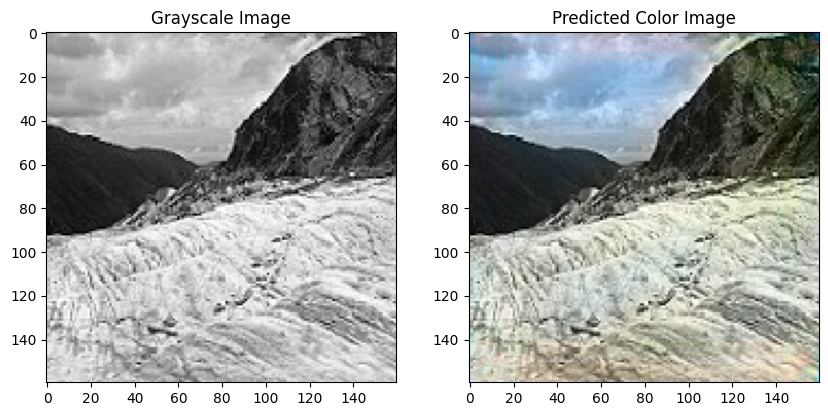

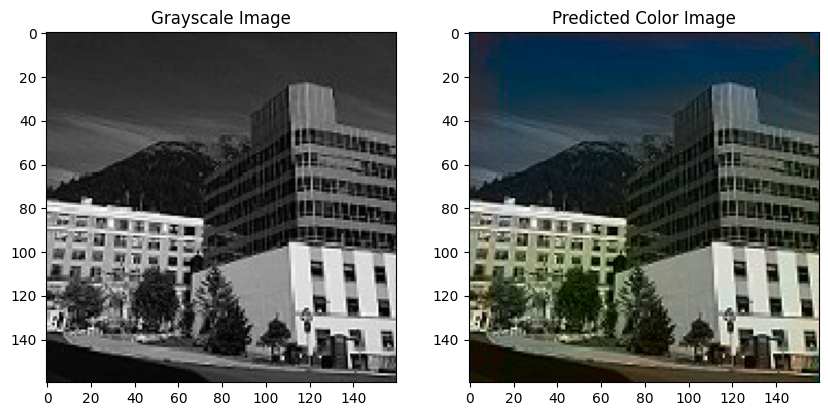

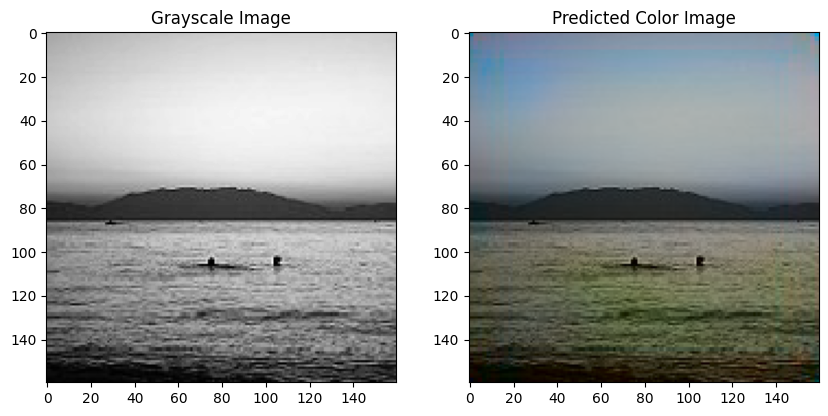

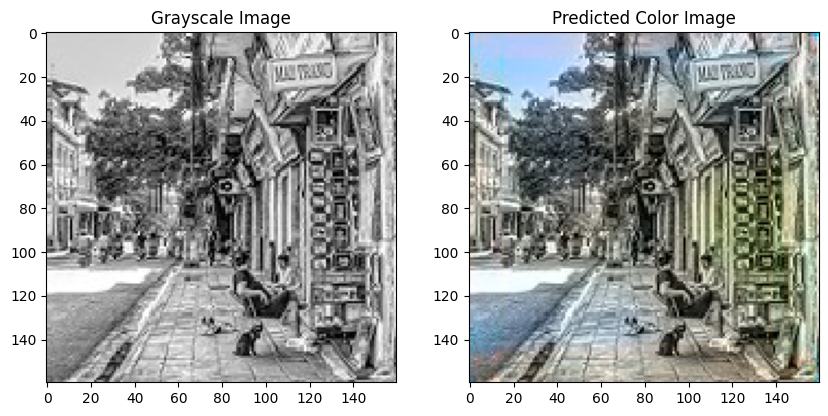

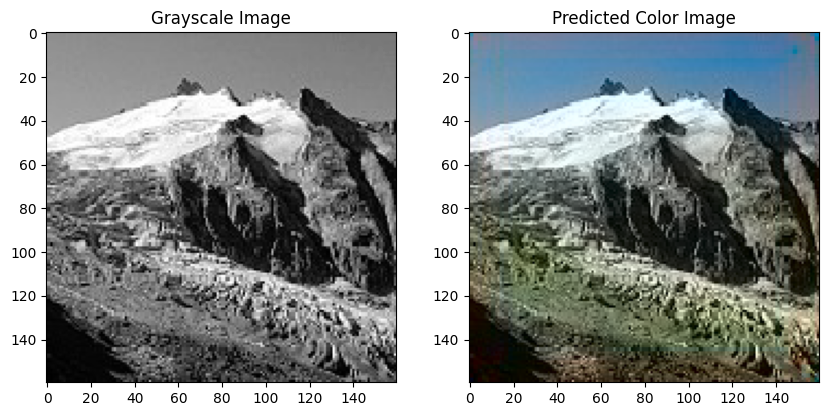

In [19]:
##Train Data
i=0
while i<5:
    test_img,test_label, image_name = next(iter(train_dataloader))
    pred = model.forward(test_img[0].float().to('cuda').view(1,1,160,160))
    lab_pred = torch.cat((test_img[0].view(1,160,160),pred[0].cpu()),dim=0)
    lab_pred_inv_scaled = lab_pred.permute(1,2,0) * torch.tensor([100,255,255]) - torch.tensor([0,128,128])
    rgb_pred = lab2rgb(lab_pred_inv_scaled.detach().numpy())

    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(test_img[0].permute(1,2,0),cmap='gray')
    plt.title('Grayscale Image')
    plt.subplot(222)
    plt.imshow(rgb_pred)
    plt.title('Predicted Color Image')
    plt.show()
    i+=1

0.22011008858680725


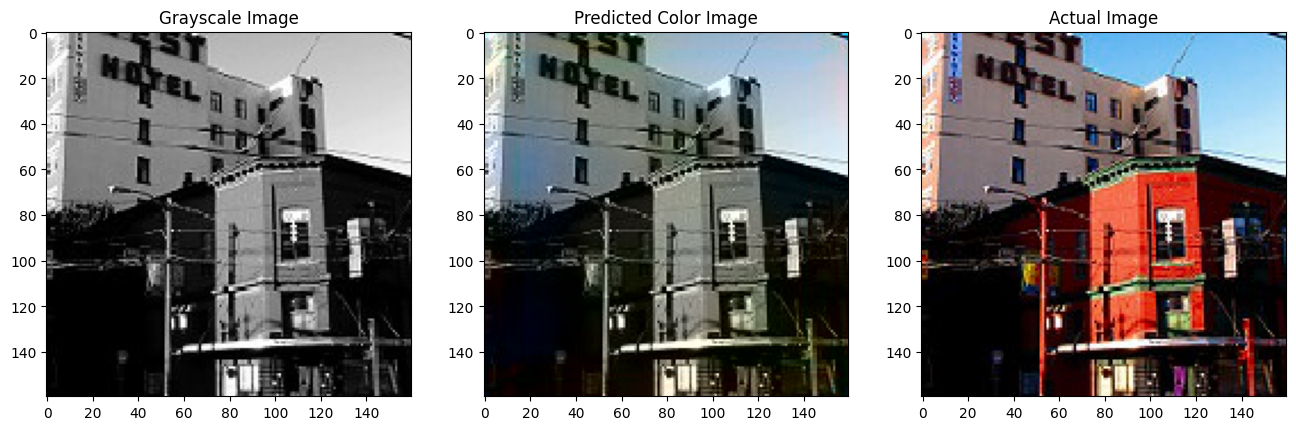

In [25]:
##Test Data
from sklearn.metrics import precision_score, accuracy_score

from PIL import Image
pred_losses = []
rms_array = []
rms_percent = []

i=0
test_image_num = len(test_indices)

while i<test_image_num:

    test_img,test_label,image_name = next(iter(test_dataloader))
    pred = model.forward(test_img[0].float().to('cuda').view(1,1,160,160))
    lab_pred = torch.cat((test_img[0].view(1,160,160),pred[0].cpu()),dim=0)
    lab_pred_inv_scaled = lab_pred.permute(1,2,0) * torch.tensor([100,255,255]) - torch.tensor([0,128,128])
    rgb_pred = lab2rgb(lab_pred_inv_scaled.detach().numpy())

    labels = test_label.float().to('cuda')
    loss = criterion(pred, labels)
    pred_losses.append((i,loss.item() * test_img.size(0)))
    print(loss.item() * test_img.size(0))

    fig = plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(test_img[0].permute(1,2,0),cmap='gray')
    plt.title('Grayscale Image')
    #plt.show()

    plt.subplot(132)
    plt.imshow(rgb_pred)
    plt.title('Predicted Color Image')
    #plt.show()

    plt.subplot(133)
    color_image = torch.cat((test_img[0].view(1,160,160),test_label[0]),dim=0).permute(1,2,0)
    color_image = color_image * torch.tensor([100,255,255]) -torch.tensor([0,128,128])
    color_image = lab2rgb(color_image)
    plt.imshow(color_image)

    file_name = image_name[0].rsplit('.', maxsplit=1)[0]
    path = "pathOnDisk" + experiment +"\\Images\\"

    col_img = Image.fromarray((rgb_pred * 255).astype(np.uint8))
    col_img.save(path+"\\Out\\" + file_name+".png")

    plt.title('Actual Image')

    plt.savefig(path+file_name+".png",bbox_inches='tight')

    accuracy = np.square(np.subtract(rgb_pred, color_image)).mean()
    rms_array.append((file_name, accuracy))

    i+=1

with open( path+'test.txt', 'w') as fp:
        fp.write('\n'.join('%s , %s' % x for x in pred_losses))

with open( path+'accuracy.txt', 'w') as fp:
        fp.write('\n'.join('%s , %s' % x for x in rms_array))

In [ ]:
#Save the model
torch.save(model, "C:\\Users\\Ankit\\Documents\\" + experiment +"\\model")